# Precomputed knn
The purpose of this notebook is to explore some cases where using a precomputed_knn might be useful and then discuss how we can obtain reproducible results with it. 

## Practical Uses

### Trying UMAP with various parameters
Let's look at how we can use precomputed_knn to save time. First we will test it out on MNIST which has 70,000 samples of 784 dimensions. If we want to test out a series of n_neighbors and min_dist parameters, we might lose quite a bit of time recomputing the knn matrices for our data. Instead, we can compute the knn for the largest n_neighbors we wish to analyze and then feed that precomputed_knn to UMAP. UMAP will automatically prune it to the right n_neighbors value and skip the nearest neighbors step, saving us a lot of time.

We note that we don't use a random state in order to leverage UMAP's parallelization and speed up the calculations.

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import umap
import umap.plot
from umap.umap_ import nearest_neighbors

data, labels = fetch_openml('mnist_784', version=1, return_X_y=True)
labels = np.asarray(labels, dtype=np.int32)

n_neighbors = [5, 50, 100, 250]
min_dists = [0, 0.2, 0.5, 0.9]
normal_embeddings = np.zeros((4, 4, 70000, 2))
precomputed_knn_embeddings = np.zeros((4, 4, 70000, 2))

In [2]:
%%time
# UMAP run on the grid of parameters without precomputed_knn
for i, k in enumerate(n_neighbors):
    for j, dist in enumerate(min_dists):
        normal_embeddings[i, j] = umap.UMAP(n_neighbors=k,
                                            min_dist=dist,
                                           ).fit_transform(data)
print("\033[1m"+"Time taken to compute UMAP on grid of parameters:\033[0m")

Time taken to compute UMAP on grid of parameters:
Wall time: 31min 57s


In [3]:
%%time
# UMAP run on list of n_neighbors without precomputed_knn

# We compute the knn for max(n_neighbors)=250
mnist_knn = nearest_neighbors(data,
                              n_neighbors=250,
                              metric="euclidean",
                              metric_kwds=None,
                              angular=False,
                              random_state=None,
                             )
# Now we compute the embeddings for the grid of parameters
for i, k in enumerate(n_neighbors):
    for j, dist in enumerate(min_dists):
        precomputed_knn_embeddings[i, j] = umap.UMAP(n_neighbors=k,
                                                      min_dist=dist,
                                                      precomputed_knn=mnist_knn,
                                                      ).fit_transform(data)
print("\033[1m"+"Time taken to compute UMAP on grid of parameters with precomputed_knn:\033[0m")

Time taken to compute UMAP on grid of parameters with precomputed_knn:
Wall time: 17min 54s


Using a precomputed_knn we have cut the computation time in half! Observe that half of our n_neighbors values are relatively small. If instead, we had had a higher distribution of values, the time savings would have been even greater.

With this, we can easily visualize how the n_neighbors parameter affects our embedding.

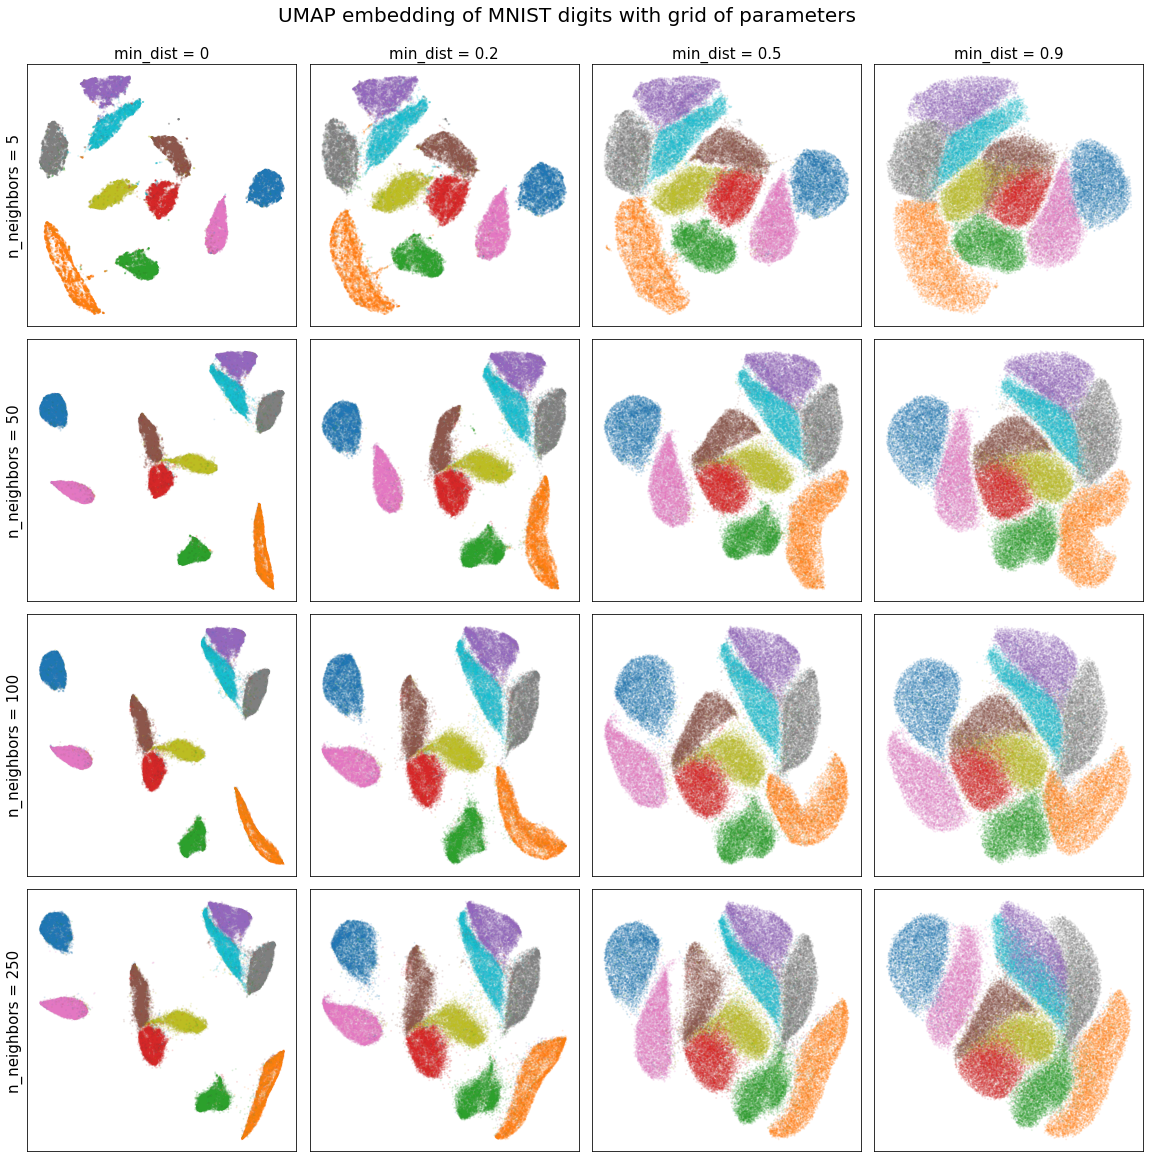

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        ax.scatter(precomputed_knn_embeddings[i, j, :, 0],
                   precomputed_knn_embeddings[i, j, :, 1],
                   c=labels / 9,
                   cmap='tab10',
                   alpha=0.1,
                   s=1,
                   )
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title("min_dist = {}".format(min_dists[j]), size=15)
        if j == 0:
            ax.set_ylabel("n_neighbors = {}".format(n_neighbors[i]), size=15)
fig.suptitle("UMAP embedding of MNIST digits with grid of parameters", y=0.92, size=20)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

We see that in this case, the embedding is robust to the choice of n_neighbors and that lower min_dist values simply pack the clusters more tightly.

## Reproducibility
We strongly recommend that you review the UMAP [reproducibility page](https://umap-learn.readthedocs.io/en/latest/reproducibility.html) in the docs before attempting to reproduce results with *precomputed_knn*.
### Standard Case
Out of the box, UMAP with precomputed_knn supports creating reproducible results. This works in exactly the same way as regular UMAP, where, the user can set a random seed state to ensure that results can be reproduced exactly. However, some important considerations must be taken into account. 

UMAP embeddings are entirely dependent on first, computing the graphical representation in higher dimensions and second, learning an embedding that preserves the structure of that graph. Recall that our graphical representation is based on the k-nn graph of our data. If we have two different k-nn graphs, then we will naturally have two different graphical representations of our data. Therefore, **we can only ensure reproducible results when we use the same k-nn graph**. In our case, this means that all reproducible results are tied to three values: 

<ol>
    <li>The random seed when computing the k-nn.</li>
    <li>The n_neighbors value when computing the k-nn.</li>
    <li>The random seed when running UMAP.</li>
</ol>

Two different runs of UMAP, with these three values being equal, are guaranteed to return the same result. Let's look at how this works with an example. To do this, we'll create some data to work with; three random blobs in 60-dimensional space.

In [6]:
y = np.random.rand(1700, 60)
X = np.concatenate((y+20, y, y-20))
synthetic_labels = np.repeat([1, 2, 3], repeats=1700)

With the data in hand, we can fix the three parameters listed above and see how two different UMAP runs give the same result. To avoid confusion we'll assume that the UMAP random seed is the same value as the knn random seed.

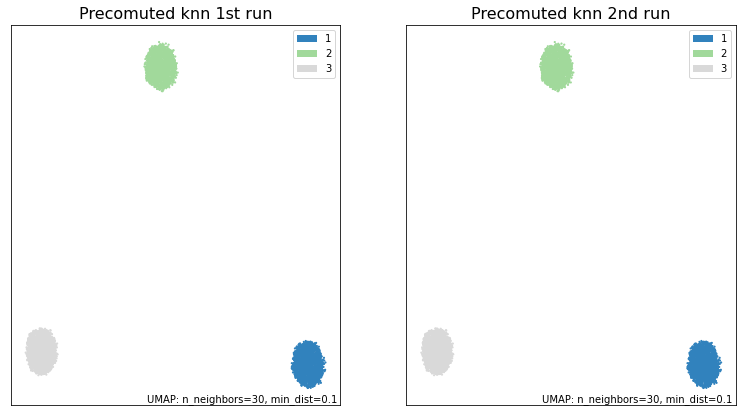

Are the embeddings for knn_umap and knn_umap2 the same?
True


In [7]:
import umap.plot
random_seed = 10

knn = nearest_neighbors(
                        X, 
                        n_neighbors=50,
                        metric='euclidean',
                        metric_kwds=None,
                        angular=False,
                        random_state=random_seed,
                        )

knn_umap = umap.UMAP(n_neighbors=30, precomputed_knn=knn, random_state=random_seed).fit(X)
knn_umap2 = umap.UMAP(n_neighbors=30, precomputed_knn=knn, random_state=random_seed).fit(X)

fig, ax = plt.subplots(1, 2, figsize=(13,7))
umap.plot.points(knn_umap, labels=synthetic_labels, ax=ax[0], theme='green')
umap.plot.points(knn_umap2, labels=synthetic_labels, ax=ax[1], theme='green')
ax[0].set_title("Precomuted knn 1st run", size=16)
ax[1].set_title("Precomuted knn 2nd run", size=16)
plt.show()

print("\033[1m"+"Are the embeddings for knn_umap and knn_umap2 the same?\033[0m")
print((knn_umap.embedding_ == knn_umap2.embedding_).all())

As we can see, by fixing the *random_seed* and the *n_neighbors* for the knn, we have been able to obtain identical results from both UMAP runs. In contrast, if these differ, we can't gaurantee the same result.

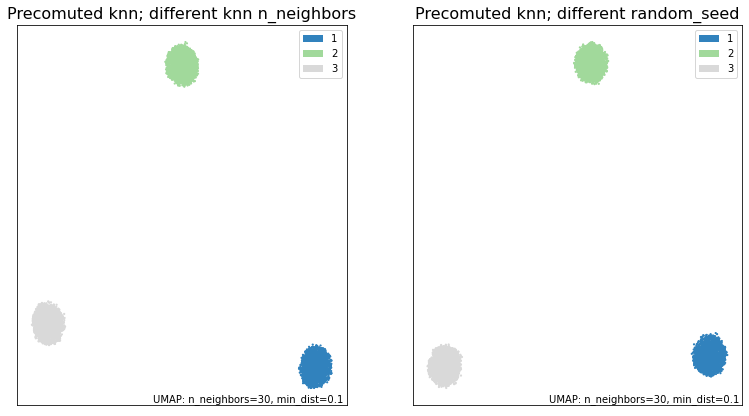

Are the embeddings for knn_umap and knn_umap3 the same?
False
Are the embeddings for knn_umap and knn_umap4 the same?
False


In [8]:
random_seed2 = 15

# Different n_neighbors
knn3 = nearest_neighbors(
                        X, 
                        n_neighbors=40,
                        metric='euclidean',
                        metric_kwds=None,
                        angular=False,
                        random_state=random_seed,
                        )
# Different random seed
knn4 = nearest_neighbors(
                        X, 
                        n_neighbors=50,
                        metric='euclidean',
                        metric_kwds=None,
                        angular=False,
                        random_state=random_seed2,
                        )

knn_umap3 = umap.UMAP(n_neighbors=30, precomputed_knn=knn3, random_state=random_seed).fit(X)
knn_umap4 = umap.UMAP(n_neighbors=30, precomputed_knn=knn4, random_state=random_seed2).fit(X)

fig, ax = plt.subplots(1, 2, figsize=(13,7))
umap.plot.points(knn_umap3, labels=synthetic_labels, ax=ax[0], theme='green')
umap.plot.points(knn_umap4, labels=synthetic_labels, ax=ax[1], theme='green')
ax[0].set_title("Precomuted knn; different knn n_neighbors", size=16)
ax[1].set_title("Precomuted knn; different random_seed", size=16)
plt.show()

print("\033[1m"+"Are the embeddings for knn_umap and knn_umap3 the same?\033[0m")
print((knn_umap.embedding_ == knn_umap3.embedding_).all())

print("\033[1m"+"Are the embeddings for knn_umap and knn_umap4 the same?\033[0m")
print((knn_umap.embedding_ == knn_umap4.embedding_).all())

Without those three parameters being equal between runs, we have obtained different results.

### Reproducing normal UMAP with precomputed_knn
With some extra considerations, we can also reproduce regular precomputed_knn results with normal UMAP results and vice-versa. As in the previous case, we must keep in mind that the k-nn graphs have to be same. Additionaly, we also must consider how UMAP uses the *random_seed* that we provide it. 

If you provide UMAP a *random_seed*, it converts it into an *np.random.RandomState* (RNG). This RNG is then used to fix the state for all the relevant steps in the algorithm. The important thing to note, is that the RNG is mutated everytime it's used. So, if we want to reproduce results with precomputed_knn we'll have to mimic how UMAP uses manipulates the RNG when calling the *fit()* function. 

For more information on random states and their behavior please refer to [[1]](https://scikit-learn.org/dev/common_pitfalls.html#randomness). 

We'll look at one example of how this can be accomplished. Other cases can be easily infered from this. Using the same random blobs as before, we seek to run UMAP normally and then reproduce the results with a precomputed_knn. To accomplish this, we have to create a new k-nn graph using the *nearest_neighbors()* function in the same way that *umap.fit()* would.

In [16]:
from sklearn.utils import check_random_state

# First we run the normal UMAP to compare with
random_seed3 = 12
normal_umap = umap.UMAP(n_neighbors=30, random_state=random_seed3).fit(X)

# Now we run precomputed_knn UMAP
random_state3 = check_random_state(random_seed3)
# random_state3 = numpy.random.RandomState(random_seed3)
knn5 = nearest_neighbors(
                        X, 
                        n_neighbors=30,
                        metric='euclidean',
                        metric_kwds=None,
                        angular=False,
                        random_state=random_state3,
                        )
# This mutated RNG can now be fed into precompute_knn UMAP to obtain
# the same results as in normal UMAP
knn_umap5 = umap.UMAP(n_neighbors=30, 
                      precomputed_knn=knn5, 
                      random_state=random_state3,  # <--- This is a RNG
                     ).fit(X)

Note that in this case we use an np.random.RandomState because we want to ensure that our RNG is mutated in exactly the same way that UMAP normally does. Equivalently, we could call *numpy.random.RandomState*. 

Graphing and comparing the embeddings, we see that we were able to obtain the same results.

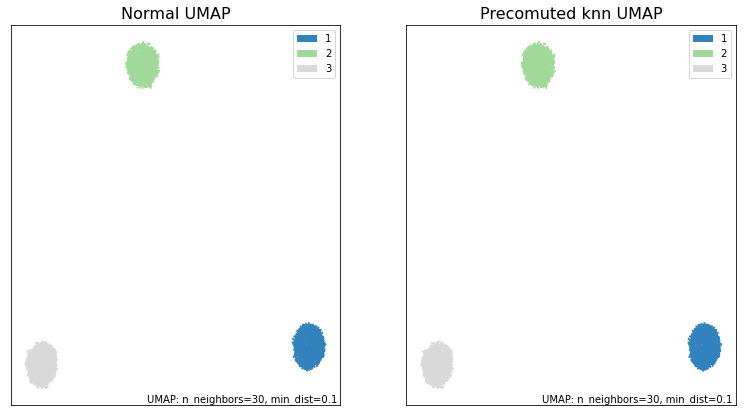

Are the embeddings for normal_umap and knn_umap5 the same?
True


In [17]:
fig, ax = plt.subplots(1, 2, figsize=(13,7))
umap.plot.points(normal_umap, labels=synthetic_labels, ax=ax[0], theme='green')
umap.plot.points(knn_umap5, labels=synthetic_labels, ax=ax[1], theme='green')
ax[0].set_title("Normal UMAP", size=16)
ax[1].set_title("Precomuted knn UMAP", size=16)
plt.show()

print("\033[1m"+"Are the embeddings for normal_umap and knn_umap5 the same?\033[0m")
print((normal_umap.embedding_ == knn_umap5.embedding_).all())